In [1]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from tensorflow.python.keras.layers import Layer
import tensorflow
import keras
import string
import numpy as np

data = pd.read_json('C:\\Users\\SATHWIKA\\Downloads\\archive (1)\\News_Category.json', lines=True)
df_review = data['short_description']

# Clean String
def cleanString(review,stopWords):
    """
    Cleans input string using set rules.
    Cleaning rules:         Every word is lemmatized and lowercased. Stopwords and non alpha-numeric words are removed.
                            Each sentence ends with a period.
    Input:   review       - string(in sentence structure)
             stopWords    - set of strings which should be removed from review
    Output:  returnString - cleaned input string
             idx_list     - list of lists, one list is equal to one sentence. In every list are the index
                            of each word as they appeared in the non cleaned sentence
                            e.g. nonCleaned = "This is a test." -> cleaned = "This test." -> cleaned_index = [[0,3]]
    """
    # Init the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(review)
    idx_list = []
    
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list

print(df_review.head())

# Parameters
# Parameters
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 100 

# Tokenization
# Word index

"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
texts = []
n = df_review.shape[0] # get number of rows in df_review
for i in range(n):
    s = df_review.iloc[i]
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
    texts.append(s)
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

print('Number of tokens: ' + str(len(word_index)))
df=data
print(df.headline[16891] + ". " + df_review[16891])
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
df_r=df.headline[16891] + ". " + df_review[16891]
cleanString(df_r, stopWords)



import os
"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
embeddings_index = {}
f = open(os.path.join(os.getcwd(), 'C:\\Users\\SATHWIKA\\Downloads\\glove.6B.100d.txt\\glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

min_wordCount = 2
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
    if word_counts[word] > min_wordCount:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    else:
        small_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')

print(str(len(word_index)-small_words-absent_words) + ' words to proceed.')

words = ['this','is','a','great','alternative','to','connection','multiple','power','strips']

# list of embeddings, where each embedding is a numpy array of shape (EMBED_SIZE,)
embeddings = [np.random.rand(EMBED_SIZE) for _ in range(len(words))]

# create DataFrame
example_df_embedding = pd.DataFrame({'word': words ,'embedding': embeddings})

# display DataFrame
display(example_df_embedding)

embedding_matrix[word_index['great']]

def split_df(dataframe, column_name, training_split, validation_split, test_split):
    """
    Splits a pandas dataframe into trainingset, validationset and testset in specified ratio.
    All sets are balanced, which means they have the same ratio for each category as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.6
             validation_split - from ]0,1[, default = 0.2        
             test_split       - from ]0,1[, default = 0.2
                                Sum of all splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
             test             - Pandas DataFrame of testset
    """
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test



train, validation, test = split_df(df, 'category',0.8,0.1,0.1)

import tensorflow as tf
from keras.models import Model
#from keras.layers import Input, Embedding, Dense, Dropout, TimeDistributed, Bidirectional, GRU
from keras.layers import Input, Embedding, Dense, Dropout, TimeDistributed, Bidirectional, GRU, Layer, Reshape
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
   
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self.trainable_params = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]
        
    
"""
Create Keras functional model for hierarchical attention network
"""
from keras import initializers
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.models import Model

from keras.layers import Input, Embedding, Dense, Dropout, TimeDistributed, Bidirectional, GRU

embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], 
                            input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='tanh', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='tanh', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(5, activation='softmax',name='output')(sent_drop)

# Model compile
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())


from keras.utils import plot_model

plot_model(model, to_file='model.png',show_shapes=True)
plot_model(wordEncoder, to_file='wordEncoder.png',show_shapes=True)

import json

data = []
with open("C:\\Users\\SATHWIKA\\Downloads\\archive (1)\\News_Category.json") as f:
    for line in f:
      obj = json.loads(line)
      data.append(obj)

from sklearn.model_selection import train_test_split

train_data, val_data, train_labels, val_labels = train_test_split(data, 
                                                                  [d['category'] for d in data],
                                                                  test_size=0.2,
                                                                  random_state=42)




<>:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


0    Health experts said it is too early to predict...
1    He was subdued by passengers and crew when he ...
2    "Until you have a dog you don't understand wha...
3    "Accidentally put grown-up toothpaste on my to...
4    Amy Cooper accused investment firm Franklin Te...
Name: short_description, dtype: object


C:\Users\SATHWIKA\AppData\Local\Temp/ipykernel_27284/1639462062.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])


Number of tokens: 86187
Trump Administration's Shift On Marijuana Could Imperil Banking Arrangements. By forcing cannabis businesses to rely on cash, the move might make businesses, owners and employees vulnerable to theft
Found 400000 word vectors.
Total absent words are 2794 which is 3.24 % of total words
Words with 2 or less mentions 49182 which is 57.06 % of total words
34211 words to proceed.


,word,embedding
0,this,"[0.0034477370186100087, 0.546653719348276, 0.2..."
1,is,"[0.23809060013662642, 0.6892969557585003, 0.02..."
2,a,"[0.7835226967320741, 0.9044445510253484, 0.168..."
3,great,"[0.9644158873277325, 0.7143295922203509, 0.285..."
4,alternative,"[0.1341266892095727, 0.20146866537328167, 0.61..."
5,to,"[0.39614757014343127, 0.47179320591769025, 0.1..."
6,connection,"[0.11146360735205585, 0.7194823839207793, 0.76..."
7,multiple,"[0.9515988528510416, 0.7765484196273646, 0.144..."
8,power,"[0.19001084817081904, 0.47131945219686355, 0.8..."
9,strips,"[0.22222522340940065, 0.05463167200259467, 0.5..."


Total:  209527
Training:  167623 , Percentage:  0.8000066817164375
Validation:  20953 , Percentage:  0.10000143179637946
Test: 20951 , Percentage:  0.09999188648718303
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_input (InputLayer)     [(None, 50)]              0         
                                                                 
 word_embedding (Embedding)  (None, 50, 100)           8618800   
                                                                 
 word_gru (Bidirectional)    (None, 50, 100)           45600     
                                                                 
 word_dense (Dense)          (None, 50, 100)           10100     
                                                                 
 word_attention (AttentionLa  ((None, 50, 100),        200       
 yer)                         (None, 50, 100))                   
                         

In [3]:


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=5000, lower=True)
from keras.utils.np_utils import to_categorical
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# extract category from JSON data

categories = []
for item in data:
    categories.append(item['category'])
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100)

# create a label encoder to map categories to integer labels
encoder = LabelEncoder()
encoder.fit(categories)
labels = encoder.transform(categories)


# convert labels to one-hot encoding
labels_onehot = to_categorical(labels)


# split data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(padded_sequences, labels_onehot, test_size=0.2, random_state=42)


In [16]:

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=7, batch_size=50)


Epoch 1/7
3353/3353 [==============================] - 220s 64ms/step - loss: 2.6944 - accuracy: 0.3055 - val_loss: 2.3776 - val_accuracy: 0.3800
Epoch 2/7
3353/3353 [==============================] - 200s 60ms/step - loss: 2.2640 - accuracy: 0.4051 - val_loss: 2.2293 - val_accuracy: 0.4129
Epoch 3/7
3353/3353 [==============================] - 201s 60ms/step - loss: 2.1157 - accuracy: 0.4352 - val_loss: 2.1537 - val_accuracy: 0.4290
Epoch 4/7
3353/3353 [==============================] - 191s 57ms/step - loss: 2.0228 - accuracy: 0.4543 - val_loss: 2.1161 - val_accuracy: 0.4368
Epoch 5/7
3353/3353 [==============================] - 202s 60ms/step - loss: 1.9548 - accuracy: 0.4673 - val_loss: 2.1024 - val_accuracy: 0.4360
Epoch 6/7
3353/3353 [==============================] - 190s 57ms/step - loss: 1.8979 - accuracy: 0.4799 - val_loss: 2.1047 - val_accuracy: 0.4358
Epoch 7/7
3353/3353 [==============================] - 225s 67ms/step - loss: 1.8455 - accuracy: 0.4906 - val_loss: 2.1151 -

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#test_texts = ["Tatum's Layup At Buzzer Gives Celtics 115-114 Win Over Nets"]
test_texts = [ 'Cash tips for new moms', 'Breaking news: President Biden announces new policies regarding new technology', '']
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded_sequences = pad_sequences(test_sequences, maxlen=50)
predictions = model.predict(test_padded_sequences)
for i in range(len(test_texts)):
    print(test_texts[i], 'predicted category:', list(label_dict.keys())[list(label_dict.values()).index(np.argmax(predictions[i]))])

1/1 [==============================] - 0s 43ms/step
Cash tips for new moms predicted category: MONEY
Breaking news: President Biden announces new policies regarding new technology predicted category: TECH
Why cutting screen time on social media by half can restore a teen’s body image predicted category: MEDIA


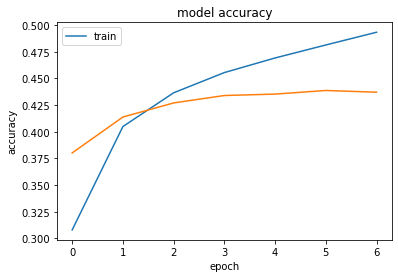

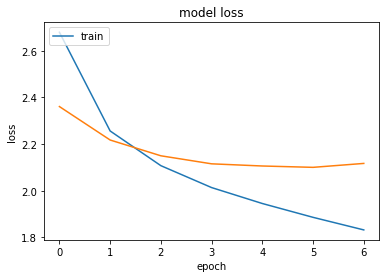

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()